In [1]:
from mpi4py import MPI
from dolfinx import mesh, plot
import pyvista

# Define nelements on each dimension of the domain
nelements = 8; p = 1

# Define the domain and generate a mesh

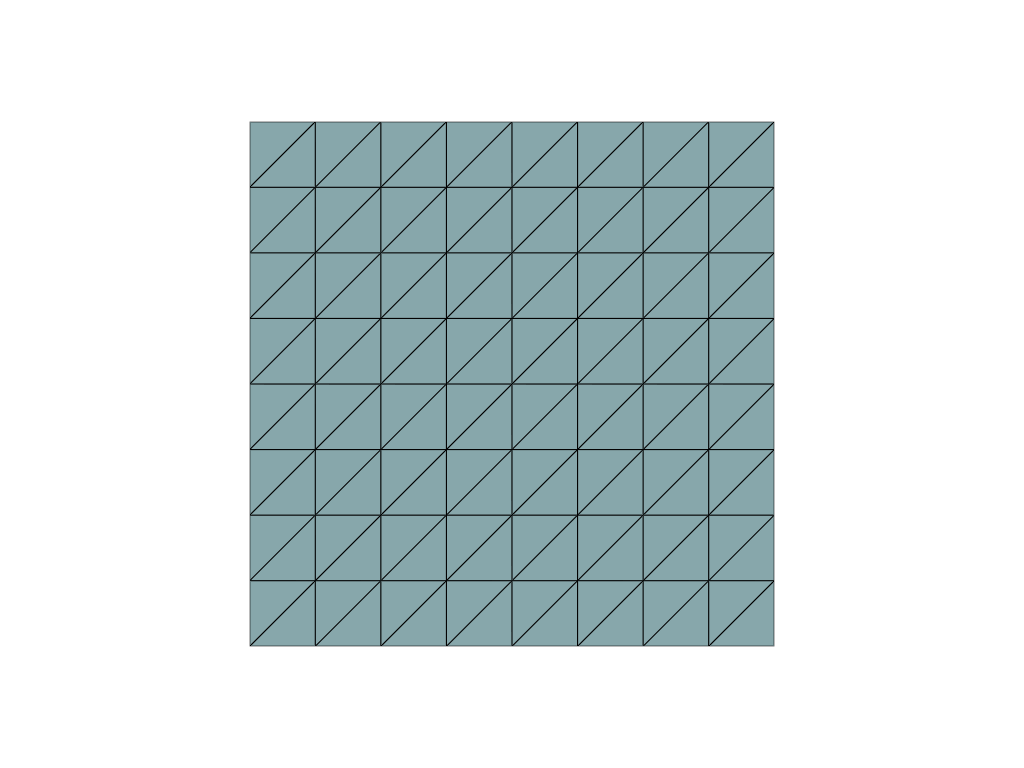

In [2]:
# load a simple domain
domain = mesh.create_unit_square(MPI.COMM_WORLD, nelements, nelements, mesh.CellType.quadrilateral)

# plotting utilities
pyvista.start_xvfb()
tdim = domain.topology.dim
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("triangular_mesh.png")

# Define the weak formulation of the PDE

The PDE we would like to solve is
\begin{align}
-\Delta u = f\ \text{on}\ \Omega,\qquad \text{such that} \qquad u|_{\partial \Omega} = u_D.
\end{align}

Define the test space $V=H^1_0(\Omega)$. Let $\tilde{u} \in H^1$ be some function which satisfies $u|_{\partial \Omega}=u_{D}$.
The variation problem is to find $u\in V+\tilde{u}$ such that
\begin{align}
a(u,v)&=L(v)&& \forall v \in {V},
\end{align}
where the bilinear form and linear functional are defined as
\begin{align}
a(u,v) &= \int_{\Omega} \nabla u \cdot \nabla v~\mathrm{d} x,\\
L(v) &= \int_{\Omega} fv~\mathrm{d} x.
\end{align}

We use the ``method of manufactured solutions'' and choose a function $u_e \in H^1$, then compute $f$ analytically to satisfy the strong form. The solution is
$$u_e=\sin(\pi x) \sin(3 \pi y).$$
Inserting $u_e$ into the original problem, we find that
$$f(x,y) = 10\pi^2 \sin(\pi x) \sin(3 \pi y) .$$
The Dirichlet data is given by the restriction of $u_e$ on the boundary.

### Define the bilinear form using UFL
On a chosen finite element space ``Vh'', in this case Lagrange polynomials of order p.

In [3]:
import ufl
from dolfinx import fem, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
import numpy as np

ue_func = lambda x: np.sin(np.pi* x[0]) * np.sin(3*np.pi*x[1])

# Finite element space Vh
Vh = fem.functionspace(domain, ("Lagrange", p))

# Body load f
f = fem.Function(Vh)
f.interpolate(lambda x: 10 * np.pi**2 * ue_func(x))

# bilinear form and linear functional
u = ufl.TrialFunction(Vh)
v = ufl.TestFunction(Vh)

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

### Assign the Dirichlet data

In [4]:
uD = fem.Function(Vh)
uD.interpolate(ue_func)

# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

boundary_dofs = fem.locate_dofs_topological(Vh, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

### Solve the linear system

In [5]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Compute the error

In [8]:
Vh_refined = fem.functionspace(domain, ("Lagrange", p+3))   # using a refined Vh space 
uex        = fem.Function(Vh_refined)
uex.interpolate(ue_func)

H1_semi_err = fem.form(ufl.inner(ufl.grad(uh - uex), ufl.grad(uh - uex)) * ufl.dx)
err_local   = fem.assemble_scalar(H1_semi_err)
err_H1_semi = np.sqrt(domain.comm.allreduce(err_local, op=MPI.SUM))

L2_error    = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2    = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

error_max = np.max(np.abs(uD.x.array-uh.x.array))
# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_H1 : {err_H1_semi+error_L2:.2e}")
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_H1 : 2.45e-01
Error_L2 : 4.93e-03
Error_max : 2.38e-03


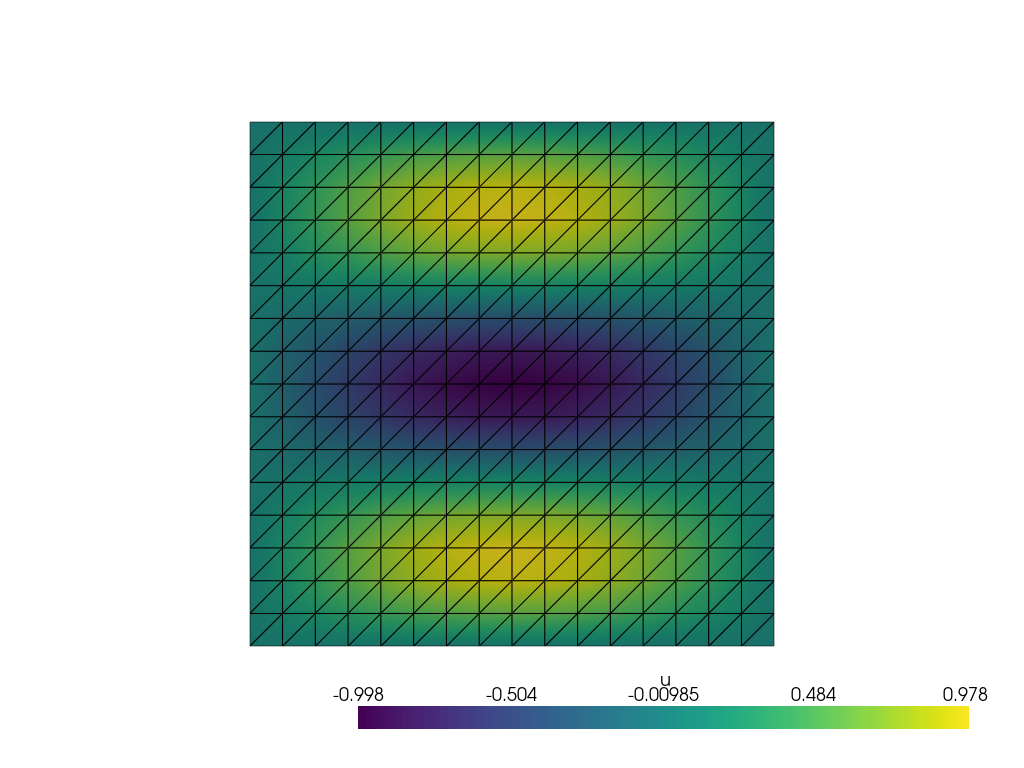

In [9]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vh)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()